# Cleaning Data For Tutoring Analysis

I tutor both Data and Full Stack students and was curious about some basic statistics. Here, I'm going through the massive dataset I have from tutoring sessions and parsing it for analysis purposes.

In [1]:
from datetime import datetime, timedelta
import missingno as msno
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# We'll use this later on to bin the topics of the tutoring sessions
with open("./raw/parse_topics.json", "r") as topics_file:
  topics_parse = json.load(topics_file)

raw_past_sessions = pd.read_csv("./raw/past.csv")
# Since I've started tutoring, there's been two systems. In one system, I worked with a student
#  for the full semester and got all their information (including graduation date)
#  In the new system, however, I work with any student at any time and am given less
#  information about them.
raw_graduated_students = pd.read_csv("./raw/students_graduated.csv")
raw_new_students = pd.read_csv("./raw/students_new.csv")

## Checking Missing Values in Dataset

### Also seeing what columns can be used

Since, as explained before, there was a switch in data availability over the course of my work. I get a lot less data on students in the new system and will be limited by what they have.

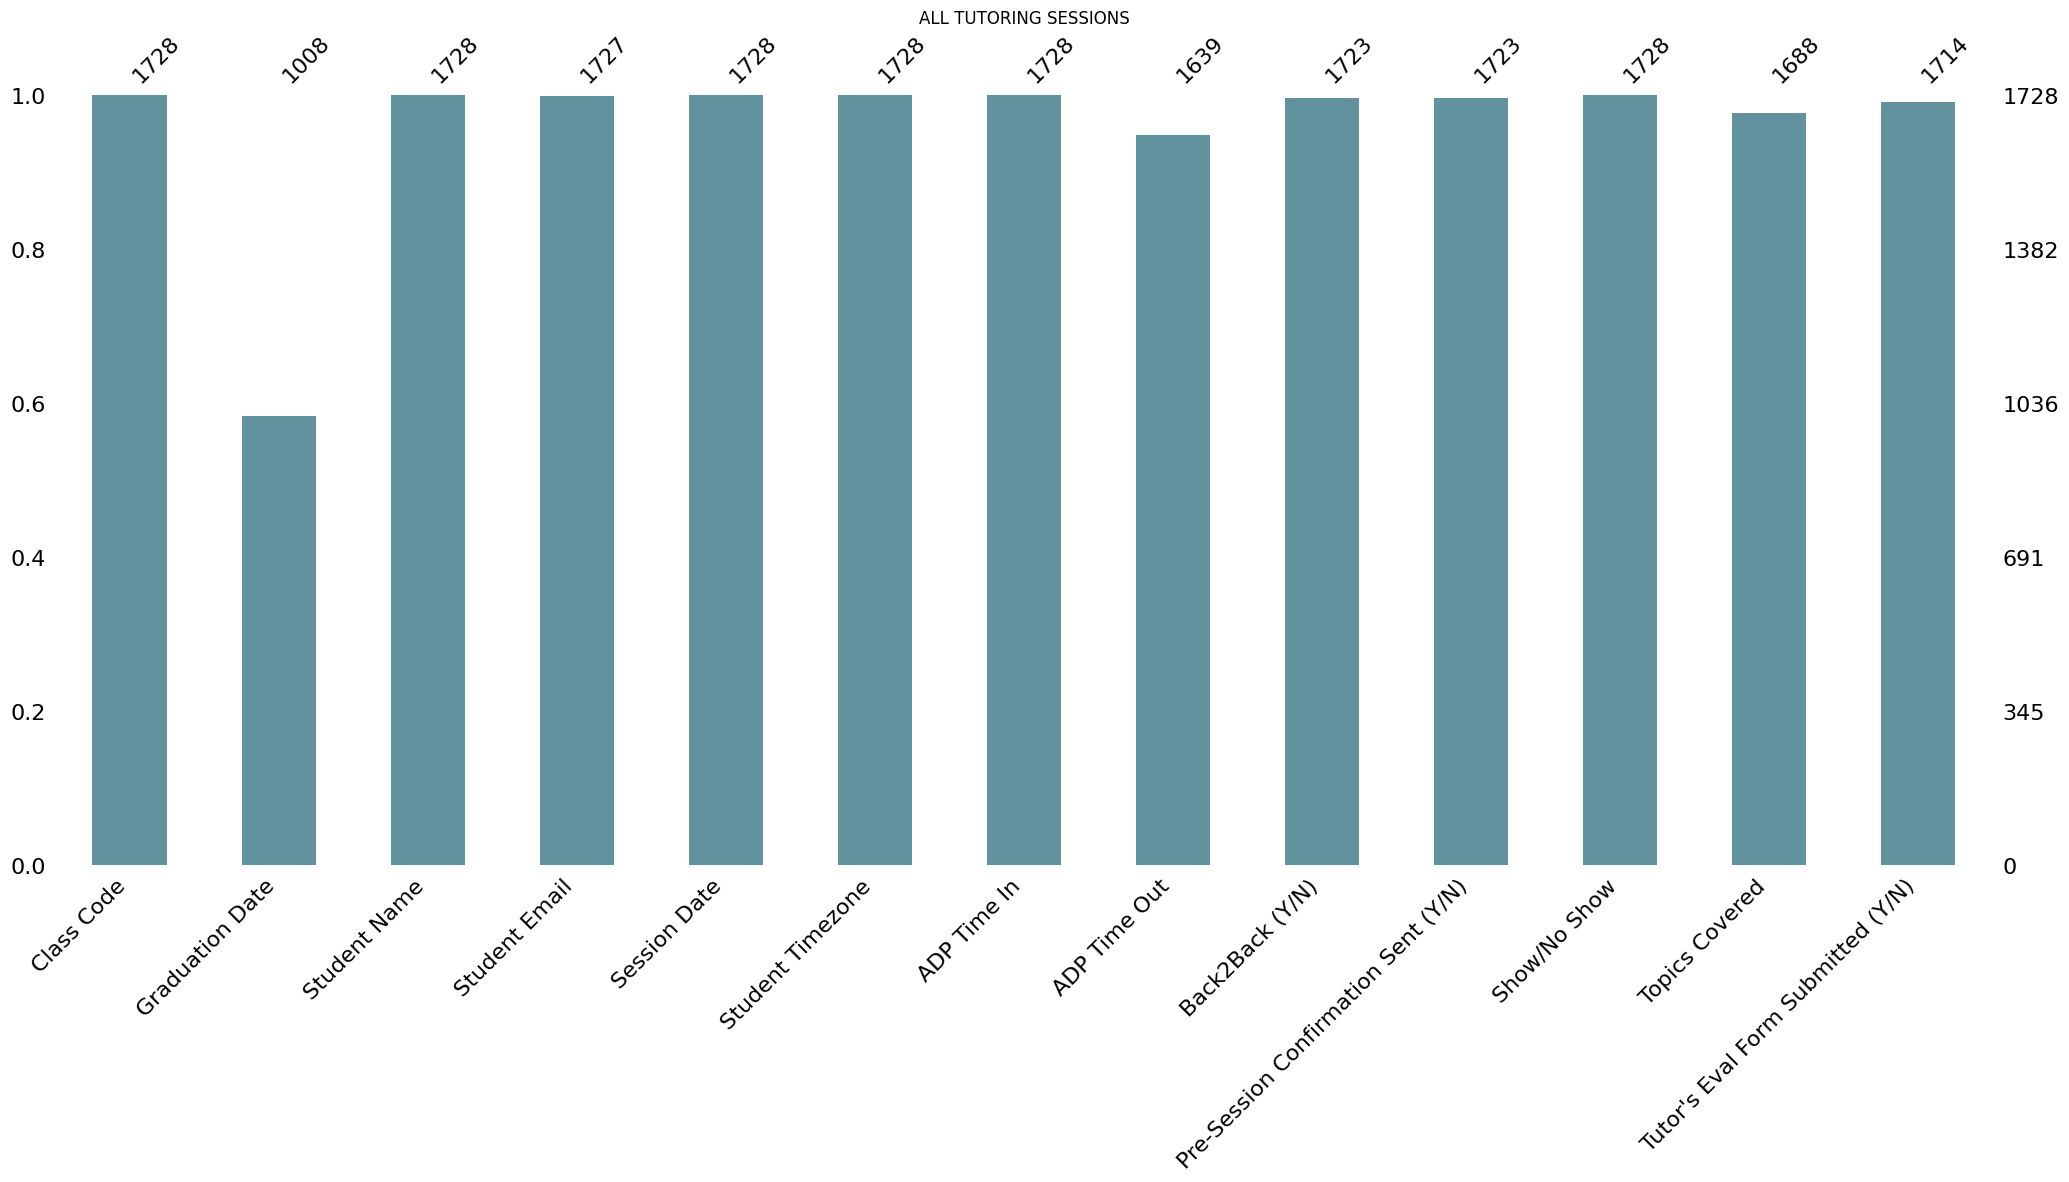

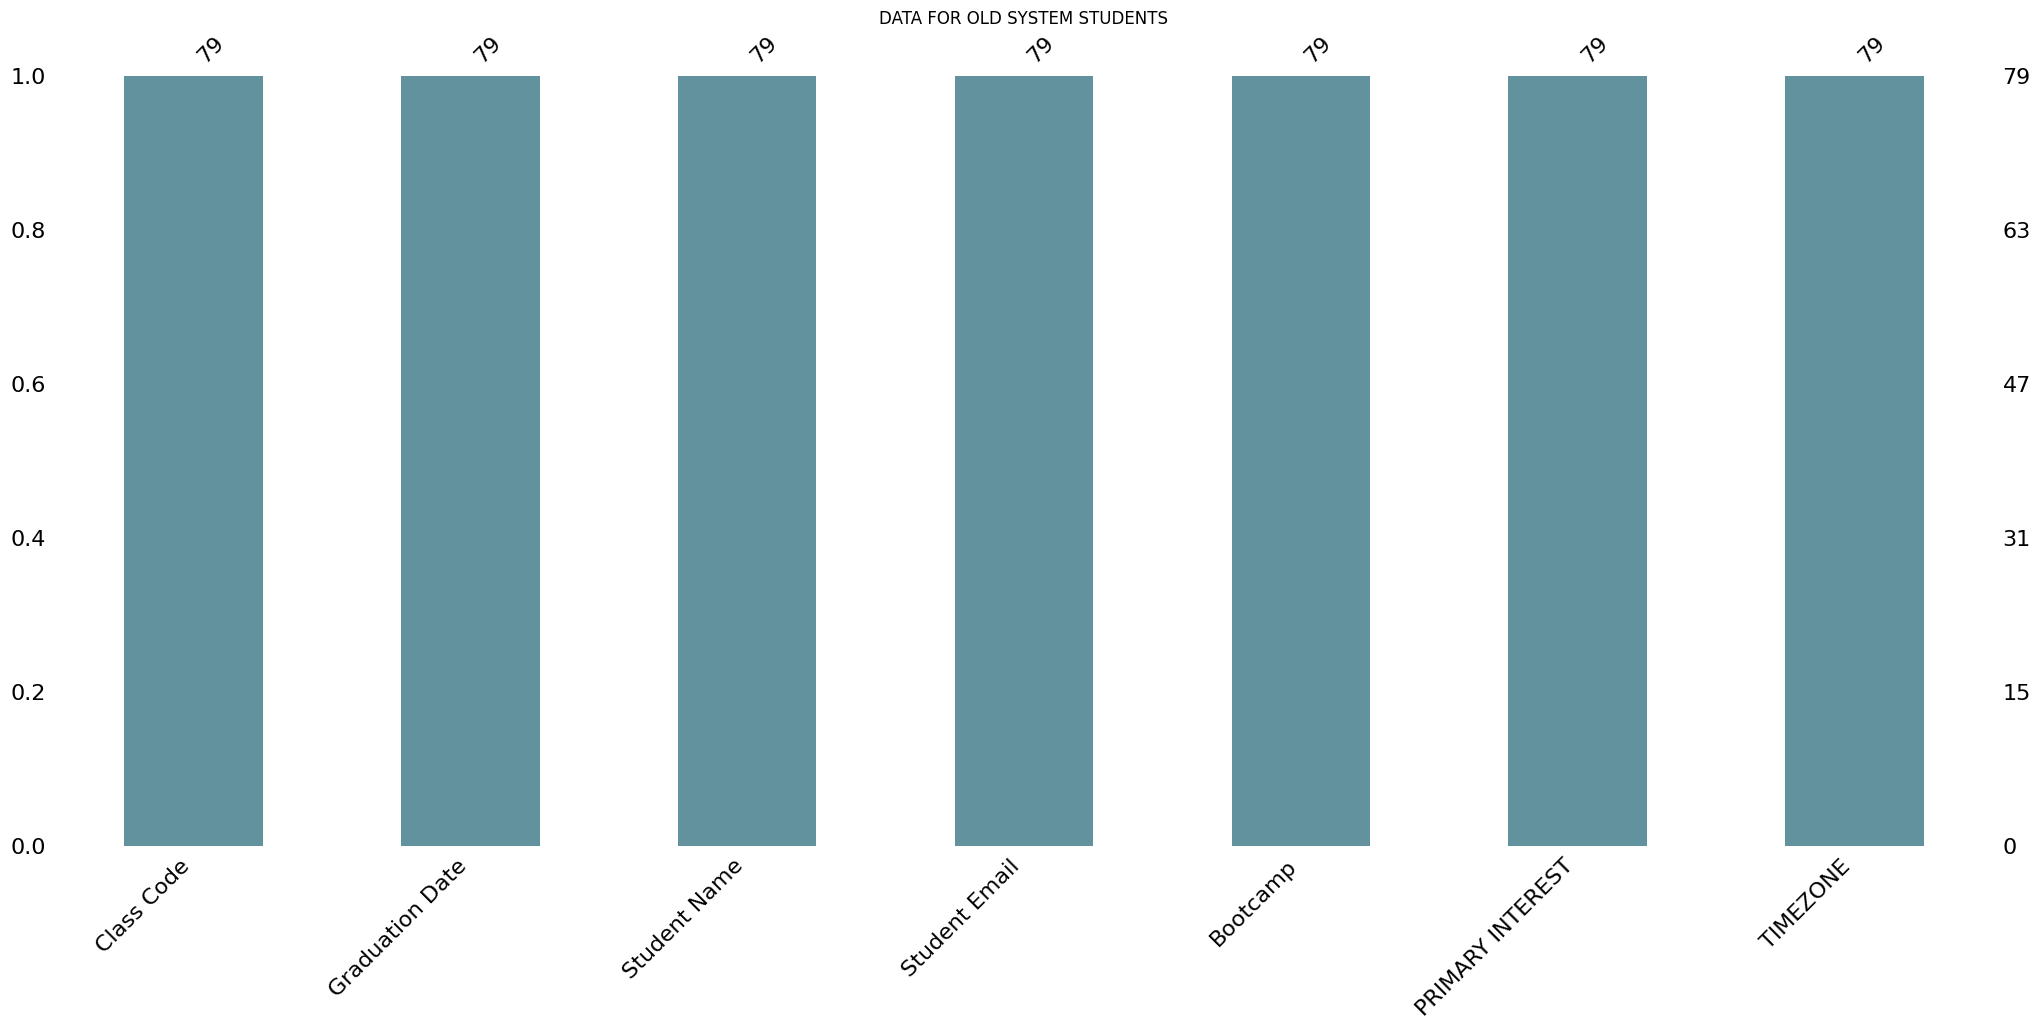

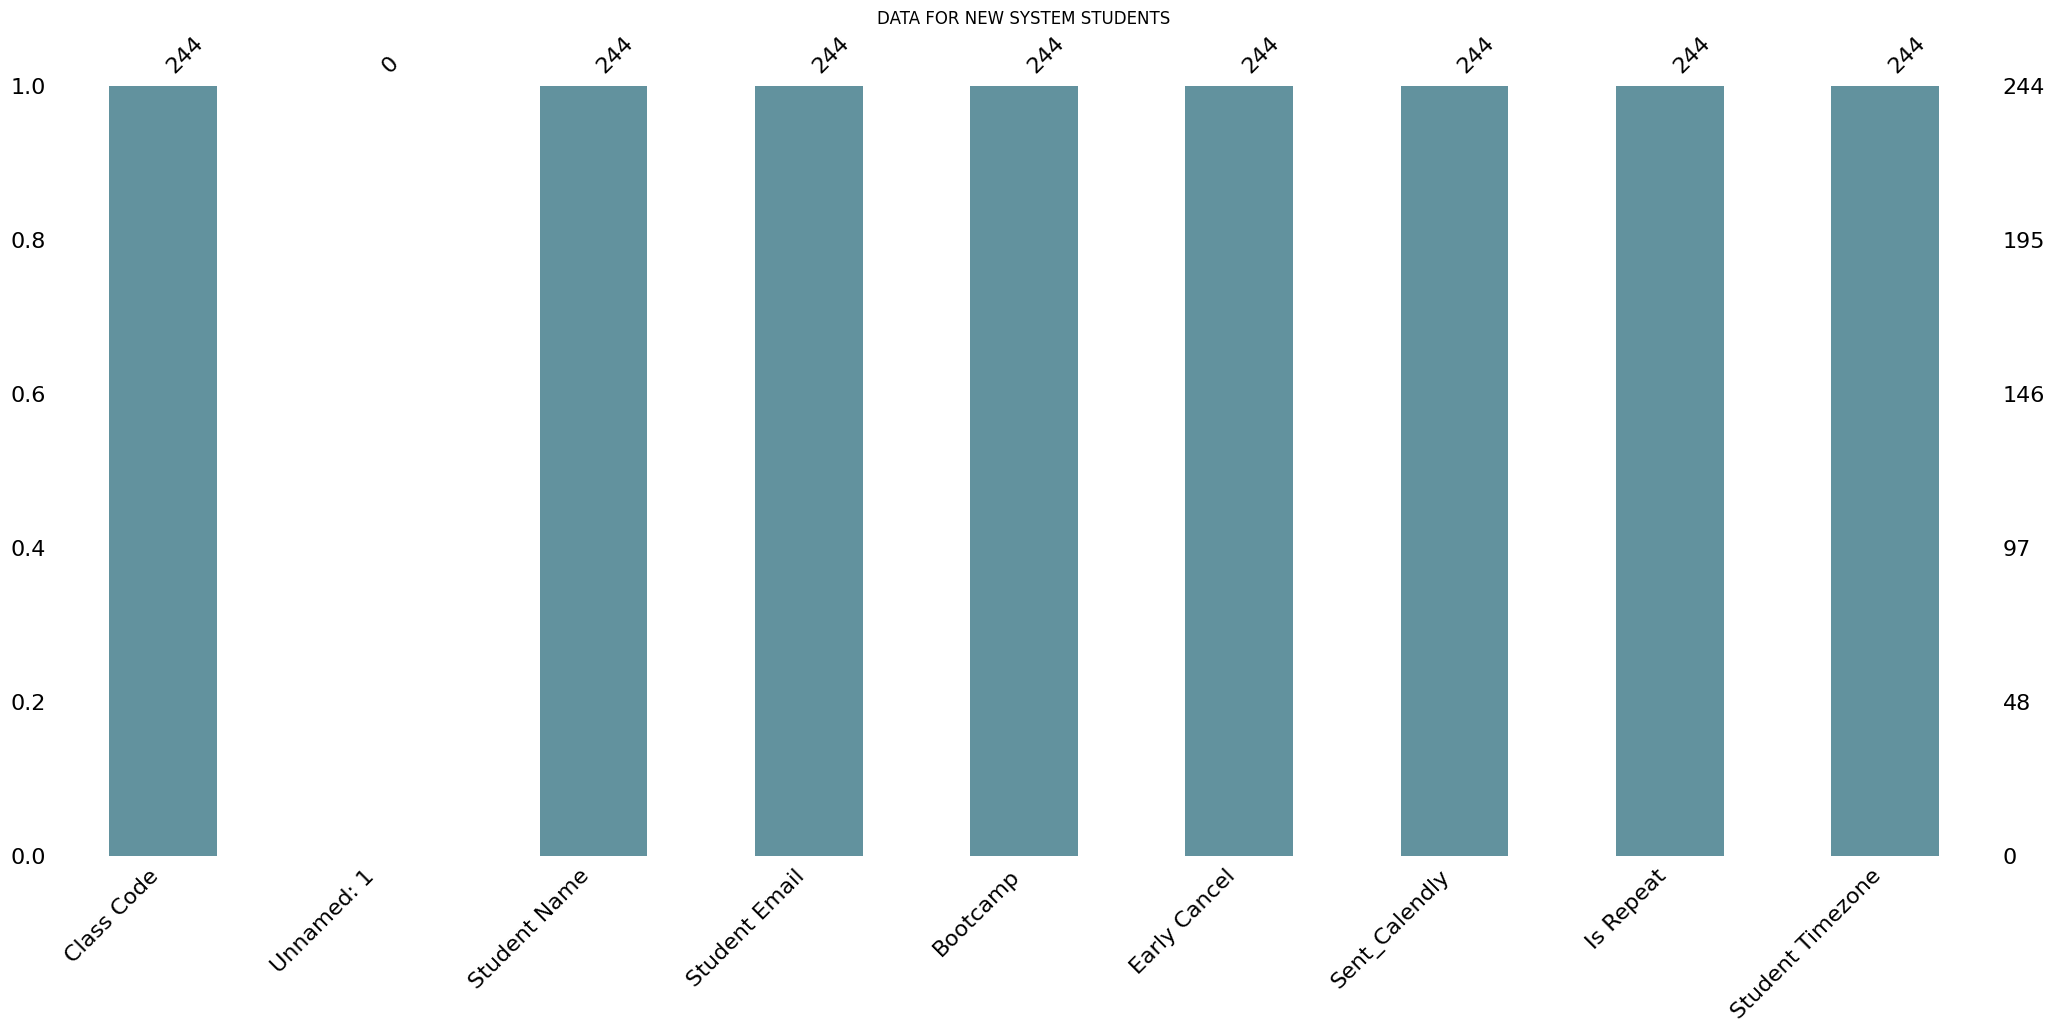

In [2]:
# Using missingno to check which columns have enough values to use for analysis
# (Note: Empty space correlates to a null / NaN value)
check_raw_with_missingno = [
    {"data": raw_past_sessions, "display": "ALL TUTORING SESSIONS"},
    {"data": raw_graduated_students, "display": "DATA FOR OLD SYSTEM STUDENTS"},
    {"data": raw_new_students, "display": "DATA FOR NEW SYSTEM STUDENTS"}
]

for dset in check_raw_with_missingno:
  msno.bar(dset["data"], color="#62929e")
  plt.title(dset["display"])
  plt.show()
  print()

In [3]:
# Here's the columns that are probably useable, given the null amounts and column changes
session_column_list = ["Student Name", "Student Email", "Session Date", "ADP Time In", "ADP Time Out", "Topics Covered"]
student_column_list = ["Student Name", "Student Email", "Bootcamp", "Student Timezone"]

# Also, I prefer doing dot notation when accessing columns, so I'm going to rename these
session_column_rename = ["NAME", "EMAIL", "DATE", "START", "END", "TOPIC"]
student_column_rename = ["NAME", "EMAIL", "BOOTCAMP", "TIMEZONE"]

# In order to do that more easily, we'll have to rename that TIMEZONE column in the old system students df
raw_graduated_students = raw_graduated_students.rename({"TIMEZONE":"Student Timezone"}, axis=1)

In [4]:
def capitalize_columns(df, column_list):
  for col in column_list:
    df[col] = df[col].str.upper()

## Selecting Columns for Past Sessions

In [5]:
# Sometimes students enter their names / emails with mixed case, so I wanted to make everything caps to make things easier to match later
# Due to privacy reasons, we'll be translating name and e-mail into an id, but I need them both here to join sessions and students
# Show/No Show and Topics Covered are capitalized for similar reasons
capitalize_columns(raw_past_sessions, ["Student Name", "Student Email", "Show/No Show", "Topics Covered"])

In [6]:
# Since this is a study of tutoring sessions I've had, I'm filtering out all sessions that students canceled or no showed on me
past_sessions = raw_past_sessions.loc[raw_past_sessions["Show/No Show"] == "SHOW", session_column_list]
past_sessions.columns = session_column_rename
print(f"{past_sessions.shape[0]:,} rows")
print("Past Sessions Columns: ", end='')
past_sessions.columns.to_list()

1,629 rows
Past Sessions Columns: 

['NAME', 'EMAIL', 'DATE', 'START', 'END', 'TOPIC']

## Selecting Columns for Students

In [7]:
print("Graduated Students: ", end='')
raw_graduated_students.columns.to_list()

Graduated Students: 

['Class Code',
 'Graduation Date',
 'Student Name',
 'Student Email',
 'Bootcamp',
 'PRIMARY INTEREST',
 'Student Timezone']

In [8]:
print("New System Students: ", end='')
raw_new_students.columns.to_list()

New System Students: 

['Class Code',
 'Unnamed: 1',
 'Student Name',
 'Student Email',
 'Bootcamp',
 'Early Cancel',
 'Sent_Calendly',
 'Is Repeat',
 'Student Timezone']

In [9]:
# As stated above, students often mix name and email capitalization, so I'm going SQL Case
capitalize_columns(raw_graduated_students, ["Student Name", "Student Email", "Bootcamp", "Student Timezone"])
capitalize_columns(raw_new_students, ["Student Name", "Student Email", "Bootcamp", "Student Timezone"])

In [10]:
# Selecting certain columns from graduated students
graduated_students = raw_graduated_students.loc[:, student_column_list]
graduated_students.columns = student_column_rename
print(f"{graduated_students.shape[0]:,} rows")
print("Graduated Students: ", end='')
graduated_students.columns.to_list()

79 rows
Graduated Students: 

['NAME', 'EMAIL', 'BOOTCAMP', 'TIMEZONE']

In [11]:
# Selecting certain columns from graduated students
new_students = raw_new_students.loc[:, student_column_list]
new_students.columns = student_column_rename
print(f"{new_students.shape[0]:,} rows")
print("New System Students: ", end='')
new_students.columns.to_list()

244 rows
New System Students: 

['NAME', 'EMAIL', 'BOOTCAMP', 'TIMEZONE']

In [12]:
# Since both dataframes now have the same columns in the same order, I can combine them
# with a union
students = pd.concat([graduated_students, new_students], axis=0)
# I'm not displaying the name or email here for privacy purposes
students.iloc[:, 2:]

,BOOTCAMP,TIMEZONE
0,FULL_STACK,PACIFIC
1,FULL_STACK,CENTRAL
2,DATA,PACIFIC
3,DATA,AWST
4,DATA,AWST
...,...,...
239,DATA,CENTRAL
240,DATA,PACIFIC
241,DATA,CENTRAL
242,FULL_STACK,PACIFIC


In [13]:
# Running this check because sometimes the pipeline accidentally allows through rows without any values
students[students.BOOTCAMP.isna()]

,NAME,EMAIL,BOOTCAMP,TIMEZONE


In [14]:
# We're using Label Encoder to quickly generate an ID for the students
# Occasionally, while working in the old system, I subbed for other tutors
# Label Encoder will file these sessions under "OTHER"
# Since we have the ids, we'll no longer need the NAME and EMAIL columns and can remove them
# for the clean datasets
student_label_enc = LabelEncoder()
vals_to_fit = students["NAME"].to_list()
vals_to_fit.append("OTHER")
student_label_enc.fit(vals_to_fit)
students["ID"] = student_label_enc.transform(students["NAME"])
past_sessions["ID"] = student_label_enc.transform(past_sessions["NAME"].map(lambda n: "OTHER" if n not in student_label_enc.classes_ else n))
students = students.drop(columns=["NAME","EMAIL"])
past_sessions = past_sessions.drop(columns=["NAME", "EMAIL"])

In [15]:
students.BOOTCAMP.value_counts()

DATA          230
FULL_STACK     84
FRONT_END       4
WEB             3
DATA            2
Name: BOOTCAMP, dtype: int64

In [16]:
# Sometimes the web students are entered under WEB or FRONT END, so I'm streamlining the
# names to DATA and FULL_STACK
students["BOOTCAMP"] = students.BOOTCAMP.map(lambda b: "DATA" if "DATA" in b else "FULL_STACK")
students.BOOTCAMP.value_counts()

DATA          232
FULL_STACK     91
Name: BOOTCAMP, dtype: int64

In [17]:
# Also streamlining some of the timezone entries
students.loc[students["TIMEZONE"] == "PERTH", "TIMEZONE"] = "AWST"
students.loc[students["TIMEZONE"] == "UK_IRELAND", "TIMEZONE"] = "IRELAND"
students.TIMEZONE.value_counts()

EASTERN     138
CENTRAL      67
PACIFIC      61
MOUNTAIN     24
IRELAND      12
AWST         11
ARIZONA       6
AEST          2
AUCKLAND      1
ATLANTIC      1
Name: TIMEZONE, dtype: int64

## Fixing Session Times

In [18]:
# There's quite a few end recordings that are off in the dataset (for example, using AM/PM)
# So we're cycling through them here and creating a clean dataset
invalid_entry_translator = {
    "100":"12:00",
    "127":"17:21",
    "168":"13:00",
    "210":"13:00",
    "215":"14:00",
    "227":"11:19",
    "251":"16:11",
    "273":"13:09",
    "361":"13:38",
    "463":"16:01",
    "490":"20:03",
    "506":"15:00",
    "516":"13:01",
    "622":"18:10",
    "778":"20:30",
    "823":"20:02",
    "864":"15:01",
    "914":"16:10",
    "931":"16:20",
    "1016":"18:20",
    "1035":"17:50",
    "1070":"16:30",
    "1086":"13:11",
    "1102":"16:20",
    "1141":"16:20",
    "1180":"10:30",
    "1194":"10:00",
    "1209":"13:00",
    "1274":"14:30",
    "1314":"18:15",
    "1350":"15:00",
    "1351":"16:00"
}

for str_idx, new_end in invalid_entry_translator.items():
  idx = int(str_idx)
  past_sessions.loc[idx, "END"] = new_end

  print(past_sessions.loc[idx])

DATE                     04/09/2021
START                         10:58
END                           12:00
TOPIC    PYTHON, MATPLOTLIB, PANDAS
ID                              195
Name: 100, dtype: object
DATE        04/24/2021
START            16:01
END              17:21
TOPIC    SUPERVISED ML
ID                  83
Name: 127, dtype: object
DATE         05/14/2021
START             12:00
END               13:00
TOPIC    PANDAS, PYTHON
ID                  244
Name: 168, dtype: object
DATE     05/27/2021
START         12:03
END           13:00
TOPIC         FLASK
ID              265
Name: 210, dtype: object
DATE          05/27/2021
START              12:00
END                14:00
TOPIC    NEURAL_NETWORKS
ID                   265
Name: 215, dtype: object
DATE          06/01/2021
START              09:49
END                11:19
TOPIC    ML_UNSUPERVISED
ID                   265
Name: 227, dtype: object
DATE      06/06/2021
START          15:01
END            16:11
TOPIC    WEBSCRAPING
I

In [19]:
# Just wanted to make sure there's a : between the hour and minutes
for col in ["START", "END"]:
  past_sessions[col] = past_sessions[col].str.replace(';', ':')

In [20]:
past_sessions.loc[past_sessions.DATE.map(lambda x: len(x.split('/')) != 3)]

,DATE,START,END,TOPIC,ID


In [21]:
# This function will extract a datetime version of the start or end time
# depending on which the user specifies in start_or_end
def extract_datetime(row, start_or_end="start"):
  date = [int(val) for val in row.DATE.split('/')]

  if date[2] == 1202:
    date [2] = 2012
  elif date[2] == 2921:
    date[2] = 2021

  try:
    start_hours, start_minutes = [int(val) for val in row.START.split(":")]
    end_hours, end_minutes = [int(val) for val in row.END.split(":")]
  except:
    start_hours, start_minutes = [int(val) for val in row.START.split(":")]
    end_hours = start_hours + 1
    end_minutes = start_minutes

  if start_hours > end_hours:
    print(row.name, end=", ")

  if start_hours >= 24:
    start_hours = 0
  elif end_hours >= 24:
    end_hours = 0

  if start_or_end == "start":
    return datetime(date[2], date[0], date[1], start_hours, start_minutes)
  else:
    try:
      return datetime(date[2], date[0], date[1], end_hours, end_minutes)
    except Exception as e:
      print(row.name, e)
      return

# Creating a datetime version of Start and End times so we can calculate the duration of the session
past_sessions["START_FULL"] = past_sessions.apply(lambda row: extract_datetime(row, "start"), axis=1)
past_sessions["END_FULL"] = past_sessions.apply(lambda row: extract_datetime(row, "end"), axis=1)
past_sessions["DURATION"] = (past_sessions["END_FULL"] - past_sessions["START_FULL"]).dt.total_seconds() // 60
past_sessions

,DATE,START,END,TOPIC,ID,START_FULL,END_FULL,DURATION
0,12/09/2020,11:59,12:56,EXCEL HOMEWORK,224,2020-12-09 11:59:00,2020-12-09 12:56:00,57.0
1,12/10/2020,05:31,06:23,TAILWIND CSS; MONGOOSE,224,2020-12-10 05:31:00,2020-12-10 06:23:00,52.0
2,12/11/2020,14:00,15:00,EXCEL HOMEWORK,224,2020-12-11 14:00:00,2020-12-11 15:00:00,60.0
3,12/14/2020,15:00,16:40,VANILLA JAVASCRIPT DOM MANIPULATION,34,2020-12-14 15:00:00,2020-12-14 16:40:00,100.0
5,12/18/2020,07:59,08:55,GIT TROUBLESHOOTING,74,2020-12-18 07:59:00,2020-12-18 08:55:00,56.0
...,...,...,...,...,...,...,...,...
1723,07/13/2023,13:00,14:00,STATISTICS,210,2023-07-13 13:00:00,2023-07-13 14:00:00,60.0
1724,07/15/2023,10:30,11:50,GEOJSON,146,2023-07-15 10:30:00,2023-07-15 11:50:00,80.0
1725,07/15/2023,13:00,14:00,DATA_MUNGING,189,2023-07-15 13:00:00,2023-07-15 14:00:00,60.0
1726,07/15/2023,14:00,15:00,NODE_JS,69,2023-07-15 14:00:00,2023-07-15 15:00:00,60.0


In [22]:
# Double-checking to ensure that the session duration column looks accurate
past_sessions.DURATION.describe()

count    1629.000000
mean       64.406998
std        18.451163
min        10.000000
25%        60.000000
50%        60.000000
75%        61.000000
max       219.000000
Name: DURATION, dtype: float64

In [23]:
# Ensuring that there's no sessions here that 0 minutes or less (as this would imply an error in the start / end hour)
past_sessions.loc[past_sessions.DURATION <= 0]

,DATE,START,END,TOPIC,ID,START_FULL,END_FULL,DURATION


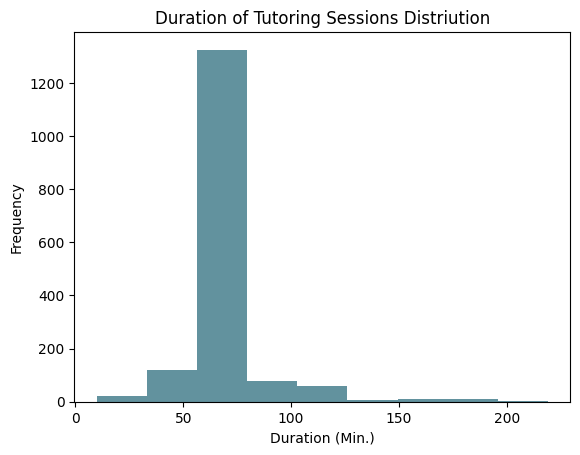

In [24]:
# Also checking the distribution of sessions to make sure that data is gathered around
# the 60 minute point since a standard session is 50 minutes
past_sessions.DURATION.plot.hist(bins=9, color="#62929e")
plt.title("Duration of Tutoring Sessions Distriution")
plt.xlabel("Duration (Min.)")
plt.show()

## Cleaning / Binning Session Topics

Since the session topics are all over the place and I want to examine how many sessions I've had on each topic, I need to go through and bin the topics by content.

In [25]:
# parse_topic_list will be used to bin the complex topics
for disp_topic, poss_topic_list in topics_parse.items():
 for poss_topic in poss_topic_list:
   past_sessions.loc[past_sessions["TOPIC"].str.contains(poss_topic, na=False, case=False), "TOPIC"] = disp_topic

past_sessions.loc[past_sessions["TOPIC"] == "R", "TOPIC"] = "STATISTICS"

In [26]:
past_sessions.loc[past_sessions["TOPIC"].isna(), "TOPIC"] = "COMPUTER_SCIENCE"

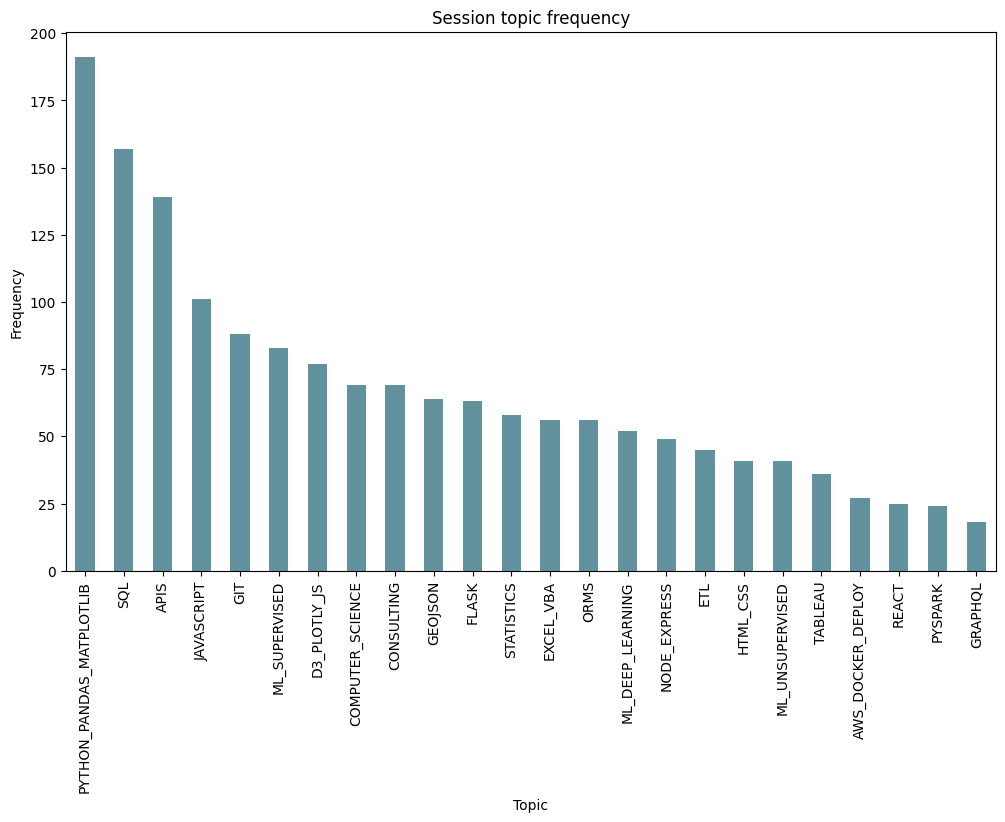

In [27]:
# Python, SQL and APIs are the most common topic, which makes sense since I primarily
# tutor Data students and there's a crossover in SQL and APIs for both bootcamps.
past_sessions.TOPIC.value_counts().plot.bar(figsize=(12,7), color="#62929e")
plt.title("Session topic frequency")
plt.ylabel("Frequency")
plt.xlabel("Topic")
plt.show()

## Preparing the Dataset for static dashboard use

In [28]:
final_sessions = past_sessions[["DATE", "START_FULL", "END_FULL", "DURATION", "ID", "TOPIC"]]
final_sessions.columns = ["DATE", "START", "END", "DURATION", "ID", "TOPIC"]
final_sessions

,DATE,START,END,DURATION,ID,TOPIC
0,12/09/2020,2020-12-09 11:59:00,2020-12-09 12:56:00,57.0,224,EXCEL_VBA
1,12/10/2020,2020-12-10 05:31:00,2020-12-10 06:23:00,52.0,224,SQL
2,12/11/2020,2020-12-11 14:00:00,2020-12-11 15:00:00,60.0,224,EXCEL_VBA
3,12/14/2020,2020-12-14 15:00:00,2020-12-14 16:40:00,100.0,34,JAVASCRIPT
5,12/18/2020,2020-12-18 07:59:00,2020-12-18 08:55:00,56.0,74,SQL
...,...,...,...,...,...,...
1723,07/13/2023,2023-07-13 13:00:00,2023-07-13 14:00:00,60.0,210,STATISTICS
1724,07/15/2023,2023-07-15 10:30:00,2023-07-15 11:50:00,80.0,146,GEOJSON
1725,07/15/2023,2023-07-15 13:00:00,2023-07-15 14:00:00,60.0,189,ETL
1726,07/15/2023,2023-07-15 14:00:00,2023-07-15 15:00:00,60.0,69,NODE_EXPRESS


In [29]:
final_students = students[["ID", "BOOTCAMP", "TIMEZONE"]]
final_students

,ID,BOOTCAMP,TIMEZONE
0,34,FULL_STACK,PACIFIC
1,47,FULL_STACK,CENTRAL
2,121,DATA,PACIFIC
3,298,DATA,AWST
4,98,DATA,AWST
...,...,...,...
239,51,DATA,CENTRAL
240,256,DATA,PACIFIC
241,293,DATA,CENTRAL
242,211,FULL_STACK,PACIFIC


In [30]:
# I'm keeping these separate for uploading to a database on local for future
# session entry (3NF)
final_sessions.to_csv("./clean/sessions.csv", index=False)
final_students.to_csv("./clean/students.csv", index=False)

In [31]:
# For the dashboard, I'll want a 0NF version, so I'll save a merged version in clean
final_merged = final_sessions.merge(final_students, how="left", on="ID")
# These are students that I subsitute taught in the old system, so I have to manually enter their Bootcamp
final_merged.loc[(final_merged.BOOTCAMP.isna()) & (final_merged.TOPIC != 'REACT'), "BOOTCAMP"] = "DATA"
final_merged.loc[(final_merged.BOOTCAMP.isna()) & (final_merged.TOPIC == 'REACT'), "BOOTCAMP"] = "FULL_STACK"
final_merged.TIMEZONE = final_merged.TIMEZONE.fillna("UNKNOWN")
print(final_merged.BOOTCAMP.value_counts())
print(final_merged.TIMEZONE.value_counts())

DATA          1299
FULL_STACK     338
Name: BOOTCAMP, dtype: int64
EASTERN     703
PACIFIC     379
CENTRAL     275
MOUNTAIN    127
AWST         89
ARIZONA      25
AEST         16
UNKNOWN      11
IRELAND      10
AUCKLAND      1
ATLANTIC      1
Name: TIMEZONE, dtype: int64


In [32]:
# Just want to check null values -- Looks good
final_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1637 entries, 0 to 1636
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DATE      1637 non-null   object        
 1   START     1637 non-null   datetime64[ns]
 2   END       1637 non-null   datetime64[ns]
 3   DURATION  1637 non-null   float64       
 4   ID        1637 non-null   int64         
 5   TOPIC     1637 non-null   object        
 6   BOOTCAMP  1637 non-null   object        
 7   TIMEZONE  1637 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 115.1+ KB


In [33]:
final_merged.to_csv("./clean/full.csv", index=False)